In [1]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
import numpy as np
import shap
import pandas as pd
from tqdm import tqdm
import random
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

import os
os.environ["CUDA_VISIBLE_DEVICES"]= "7"

def set_seed(seed):
    # Set the random seed for PyTorch on CPU and GPU
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Set the random seed for NumPy
    np.random.seed(seed)
    # Set the random seed for Python's built-in random module
    random.seed(seed)
    
seed = 300
set_seed(seed)

In [2]:
# MLP 모델 정의
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()
        self.bn1 = nn.BatchNorm1d(num_features=hidden_size1)
        self.bn2 = nn.BatchNorm1d(num_features=hidden_size2)

    def forward(self, x):
        # breakpoint()
        x = self.fc1(x)
        x = self.bn1(self.relu1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(self.relu2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [3]:
from torch.utils.data import Dataset, DataLoader, random_split

class TabularDataset(Dataset) :
    def __init__(self, X , y) :
        self.X = X
        self.y = y
    def __len__(self) :
        return len(self.X)
    def __getitem__(self,idx) :
        if isinstance(idx, torch.Tensor):
            idx = idx.tolist()
        return [self.X.iloc[idx].values, self.y.iloc[idx]]      # X가 Dataframe일 때
        # return [self.X[idx], self.y[idx]]       # X가 array일 때

In [4]:
# test에 나머지 control sample 추가해서 idx 만 반환
def divide_testset(unbalanced_data, ratio):
    # train에서 ckd, control index 확인
    total_idx = unbalanced_data.index
    ckd_idx = unbalanced_data[unbalanced_data['onset_tight'] == 1].index        # 실제 ckd
    control_idx = unbalanced_data[unbalanced_data['onset_tight'] == 0].index    # 실제 control
    # print(control_idx, ckd_idx)

    # ckd 갯수와 동일하게 control idx sampling
    rng = np.random.default_rng(seed)   # always same test set
    sampled_ckd_idx = pd.Index(rng.choice(ckd_idx, size=int(len(ckd_idx)*ratio), replace=False))
    sampled_control_idx = pd.Index(rng.choice(control_idx, size=len(sampled_ckd_idx), replace=False)) # test_ckd 갯수와 동일하게 sampling
    
    test_idx = sampled_ckd_idx.append(sampled_control_idx)
    train_idx = total_idx.difference(test_idx)

    # return 실제 ckd, 실제 ckd 갯수와 동일한 갯수의 subject, control_idx - ckd_idx
    return unbalanced_data.loc[train_idx], unbalanced_data.loc[test_idx]


# test에 나머지 control sample 추가해서 idx 만 반환
def _under_sampling_idx(unbalanced_data, seed):
    # train에서 ckd, control index 확인
    ckd_idx = unbalanced_data[unbalanced_data['onset_tight'] == 1].index        # 실제 ckd
    control_idx = unbalanced_data[unbalanced_data['onset_tight'] == 0].index    # 실제 control

    # ckd 갯수와 동일하게 control idx sampling
    """
    Control을 CKD와 어떤 비율로 뽑을지.
    """
    rng = np.random.default_rng(seed = seed) 
    sampled_control_idx = pd.Index(rng.choice(control_idx, size= len(ckd_idx), replace=False)) # ckd 갯수와 동일하게 sampling
    not_sampled_control_idx = control_idx.difference(sampled_control_idx)

    assert set(sampled_control_idx).issubset(set(control_idx))
    
    balanced_idx = sampled_control_idx.append(ckd_idx)

    # return 실제 ckd, 실제 ckd 갯수와 동일한 갯수의 subject, control_idx - ckd_idx
    return ckd_idx, sampled_control_idx, not_sampled_control_idx, balanced_idx

def undersampling(unbalanced_data, seed):
    a, b, c, d = _under_sampling_idx(unbalanced_data, seed)
    under_sampled_data = unbalanced_data.loc[d]
    X_undersampled = under_sampled_data.drop(['RID', 'onset_tight'], axis=1)
    y_undersampled = under_sampled_data['onset_tight']
    return X_undersampled, y_undersampled

def oversampling(unbalanced_dataframe, seed):
    smote = SMOTE(random_state=seed)
    temp = unbalanced_dataframe.drop(['RID'], axis=1)
    X_train, y_train = smote.fit_resample(temp, temp['onset_tight'])

    # X_train에는 RID, onset_3 없음.
    return X_train.drop(['onset_tight'], axis=1), y_train

def normalizing(X_train, X_valid, X_test):
    # pd.Dataframe -> pd.Dataframe
    columns = X_train.columns
    
    wei_train_scaler = StandardScaler()
    # wei_train_scaler =MinMaxScaler()
    X_train_scaled = wei_train_scaler.fit_transform(X_train)
    X_valid_scaled = wei_train_scaler.transform(X_valid)
    X_test_scaled = wei_train_scaler.transform(X_test)
    
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=columns, index=X_train.index)
    X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=columns, index=X_valid.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=columns, index=X_test.index)
    
    return X_train_scaled, X_valid_scaled, X_test_scaled

In [5]:
# data = pd.read_csv("/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/data/0922_data/0922_basic_food_mean.csv")
data = pd.read_csv("/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/data/0922_data/0922_basic_food_adjusted_mean.csv")

In [6]:
X_train, X_test = divide_testset(data, ratio=0.1)
X_train, y_train = undersampling(X_train, seed=100)

y_test = X_test['onset_tight']
X_test = X_test.drop(['RID', 'onset_tight'], axis=1)

X_train_scaled, _, X_test_scaled = normalizing(X_train, X_test, X_test)

X_train_scaled, y_train, X_test_scaled, y_test = X_train_scaled.astype('float32'), y_train.astype('float32'), X_test_scaled.astype('float32'), y_test.astype('float32')

In [7]:
trainset = TabularDataset(X_train_scaled , y_train)
testset = TabularDataset(X_test_scaled , y_test)

trainloader = DataLoader(trainset, batch_size=1000, shuffle=True)
testloader = DataLoader(testset, batch_size=1000, shuffle=False)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, roc_auc_score

def metric(y_test, y_pred):  # label, pred
    y_test = y_test.cpu().detach().numpy()
    y_pred = y_pred.cpu().detach().numpy()
    y_pred = y_pred.flatten()
    y_pred = np.where(y_pred > 0.5, 1, 0)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculate recall, precision, accuracy
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=1)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Calculate AUC of ROC
    auc = roc_auc_score(y_test, y_pred)
    
    # Return all metrics
    return recall, precision, accuracy, auc

In [10]:
def train(model, optimizer, criterion, epoch, train_loader, l1_lambda=0.1):
    t = time.time()
    model.train()
    for train_input, train_label in train_loader:
        train_input = train_input.cuda(device)
        train_label = train_label.cuda(device)
        optimizer.zero_grad()
        
        # breakpoint()
        output = model(train_input)
        loss_train = criterion(output.squeeze(), train_label)
            
        if l1_lambda > 0:
            l1_norm = sum(p.abs().sum() for p in model.parameters())    # l1 norm
            loss_train += l1_lambda * l1_norm
    
        recall_train, precision_train, acc_train, auc_train = metric(train_label, output)
        loss_train.backward()
        optimizer.step()
    
    print("epoch : {:04d}, loss_train: {:.4f}, recall_train: {:.4f}, precision_train: {:.4f}, acc_train: {:.4f}, auc_train: {:.4f}, time: {:.4f}s".format(
        epoch+1, loss_train.item(), recall_train.item(), precision_train.item(), acc_train.item(), auc_train.item(), time.time() - t
    ))
      
    # print("Train results ==> epoch : {:04d}, loss_train: {:.4f}, acc_train: {:.4f}, time: {:.4f}s".format(
    #     epoch+1, loss_train.item(), acc_train.item(), time.time() - t
    # ))

In [11]:
def test_CV(model, criterion, X_test, y_test):
    model.eval()
    with torch.no_grad():
        # 데이터를 GPU로 이동
        X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)
        
        # 모델 예측
        output_test = model(X_test_tensor)
        
        loss_test = criterion(output_test.squeeze(), y_test_tensor)
        
        # # 예측 결과 평가 (예측값을 0.5로 이진 분류)
        # total_label = y_test_tensor.cpu().detach().numpy()
        # total_pred = output_test.cpu().detach().numpy()
        
        # 정확도, 재현율, 정밀도, AUC 등의 메트릭 계산
        recall_test, precision_test, acc_test, auc_test = metric(y_test_tensor, output_test)
        
        # 결과 로그 출력
        # logger.info("Test set results")
        print("Test set results ==> loss= {:.4f}, recall= {:.4f}, precision= {:.4f}, accuracy= {:.4f}, AUC= {:.4f}".format(
            loss_test.item(), recall_test, precision_test, acc_test, auc_test))
        output_test = output_test.cpu().detach()
        
        return output_test, loss_test.item(), recall_test, precision_test, acc_test, auc_test

In [12]:
model = MLP(input_size=X_train.shape[1], hidden_size1=64, hidden_size2=16, output_size=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
criterion = nn.BCELoss()

# Train model
t_total = time.time()
for epoch in range(200):
    train(model, optimizer, criterion, epoch, trainloader, l1_lambda=0.01)
print("=====Optimization Finished!=====")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

outputs, _, _, _, _, _ = test_CV(model, criterion, X_test_scaled, y_test)

epoch : 0001, loss_train: 4.1799, recall_train: 0.5687, precision_train: 0.5886, acc_train: 0.5856, auc_train: 0.5856, time: 0.5724s
epoch : 0002, loss_train: 3.8639, recall_train: 0.6300, precision_train: 0.5948, acc_train: 0.6004, auc_train: 0.6004, time: 0.0514s
epoch : 0003, loss_train: 3.5524, recall_train: 0.7040, precision_train: 0.6555, acc_train: 0.6670, auc_train: 0.6670, time: 0.0461s
epoch : 0004, loss_train: 3.2518, recall_train: 0.7611, precision_train: 0.7229, acc_train: 0.7347, auc_train: 0.7347, time: 0.0465s
epoch : 0005, loss_train: 3.0054, recall_train: 0.7886, precision_train: 0.7173, acc_train: 0.7389, auc_train: 0.7389, time: 0.0456s
epoch : 0006, loss_train: 2.7875, recall_train: 0.8097, precision_train: 0.7295, acc_train: 0.7548, auc_train: 0.7548, time: 0.0460s
epoch : 0007, loss_train: 2.5575, recall_train: 0.8478, precision_train: 0.7638, acc_train: 0.7928, auc_train: 0.7928, time: 0.0460s
epoch : 0008, loss_train: 2.3737, recall_train: 0.8520, precision_tra

# Shap visualization

In [14]:
X_train_np = X_train_scaled.values
X_train_torch = torch.from_numpy(X_train_np).to(device).float()

X_test_np = X_test_scaled.values
X_test_torch = torch.from_numpy(X_test_np).to(device).float()

# get CKD, CONTROL index
ckd_idx = np.where(y_test == 1)[0]
control_idx = np.where(y_test == 0)[0]
y_test_np = y_test.values


#### DeepExplainer를 만들 때 X_test_torch랑 model을 학습할 때 사용한 training data랑 스케일이 같아야 함.
## 여기에서만 스케일이 같으면 됨.
explainer_shap = shap.DeepExplainer(model, X_train_torch)
shap_values = explainer_shap.shap_values(X_test_torch, check_additivity=False) ## very very slow  3900 row -> 118m

In [15]:
print(shap_values.shape)
print(explainer_shap.expected_value)

(104, 36)
[0.42596924]


## Summary plot

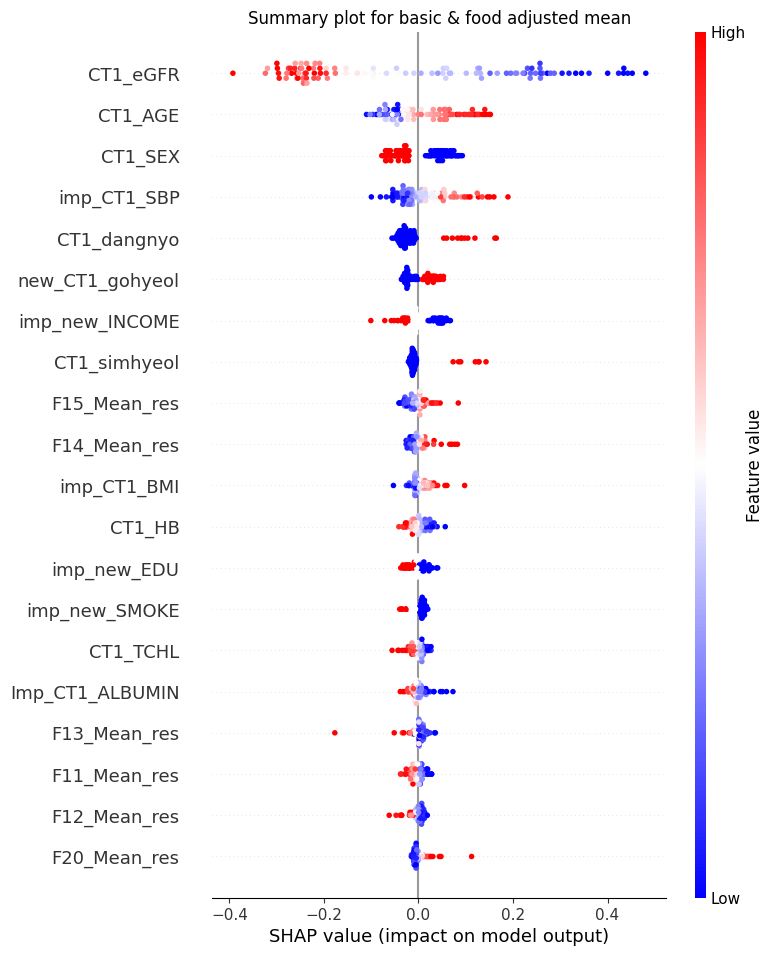

In [16]:
# 색깔이 의미하는 것은 특성 값의 크기이다.
# X축 (shap value)의 값이 크면 모델의 예측을 증가시킨다는 의미이다.
# 예를 들어, CT1_eGFR이 작은 샘플(파란색)에 대해서 shap value가 크고, CT1_eGFR이 큰 샘플(빨간색)에 대해서 shap value가 작은 걸 보면
# eGFR이 작으면 모델의 예측값을 키우고, eGFR이 크면 모델의 예측값을 작게 한다. => 모델의 예측은 키우면 CKD로 분류, 줄이면 Control로 분류.

plt.figure()
shap.summary_plot(shap_values, X_test.values, feature_names=X_train.columns.tolist(),       # X_test 자리에 (ndarray)를 넣어야 색깔이 나옴.
                  cmap='bwr', show=False)
plt.title("Summary plot for basic & food adjusted mean")
plt.show()

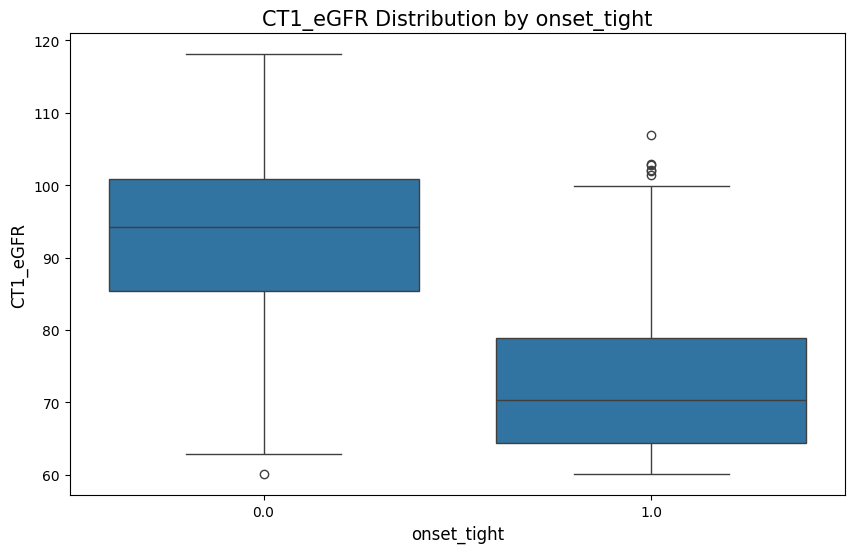

In [17]:
total_train = pd.merge(X_train, pd.DataFrame(y_train), left_index=True, right_index=True)

# Boxplot을 사용하여 "onset_tight" 별로 "CT1_eGFR" 분포 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x='onset_tight', y='CT1_eGFR', data=total_train)

# 그래프 제목과 축 레이블 설정
plt.title('CT1_eGFR Distribution by onset_tight', fontsize=15)
plt.xlabel('onset_tight', fontsize=12)
plt.ylabel('CT1_eGFR', fontsize=12)

# 그래프 표시
plt.show()

## Decision plot

### decision plot by ((CKD or Control samples) & (CKD or Control outputs))

- ex) ckd sample이 모델이 ckd output을 내는 데에 얼마나 기여했는지를 의미하는 shap_value

In [18]:
outputs.shape

torch.Size([104, 1])

In [19]:
outputs_of_ckd, outputs_of_control = outputs[:52], outputs[52:]

### For CKD test sample

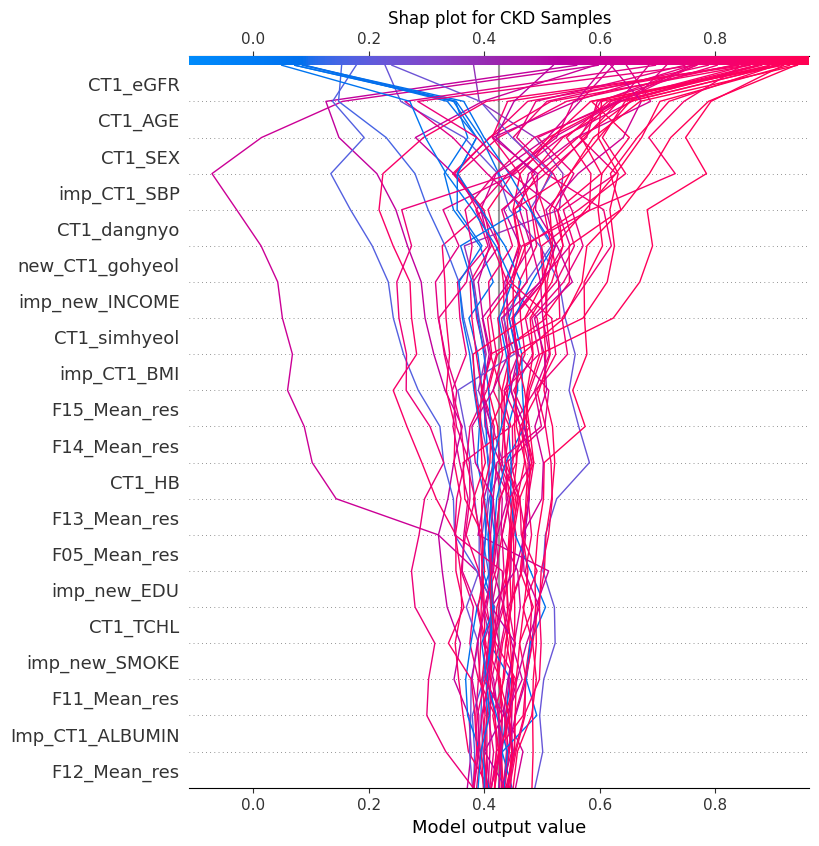

In [20]:
plt.figure()
# 아래 그림에서 위부분의 결과값은 model output을 의미한다.
# 그림에서 직선의 기울기는 각 sample의 해당 column에 대한 shap_value 임.
shap.decision_plot(explainer_shap.expected_value,    # model output들의 평균. (여기서는 c=0이라서 control output들의 평균이다.)
                   shap_values[ckd_idx],    # shape : (5, 34)
                   X_test.values[ckd_idx],    # shape : (2, 34)
                   feature_names=X_train.columns.tolist(),
                   show=False
                  )
plt.title("Shap plot for CKD Samples")
plt.show()

In [21]:
(outputs_of_ckd < 0.5)

tensor([[False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False]])

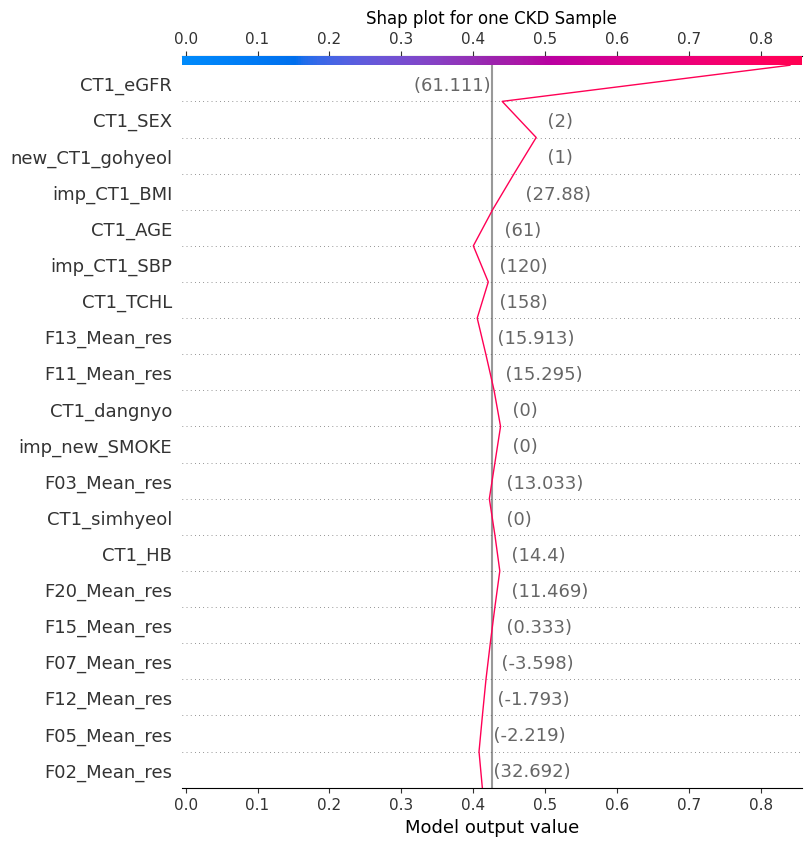

In [22]:
plt.figure()
# one ckd sample, CKD로 잘 예측한 sample.
n = 22
shap.decision_plot(explainer_shap.expected_value,
                   shap_values[n],    # shape : (5, 34)
                   X_test.values[n],    # shape : (2, 34)
                   feature_names=X_train.columns.tolist(),
                   show=False
                  )
plt.title(f"Shap plot for one CKD Sample")
plt.show()

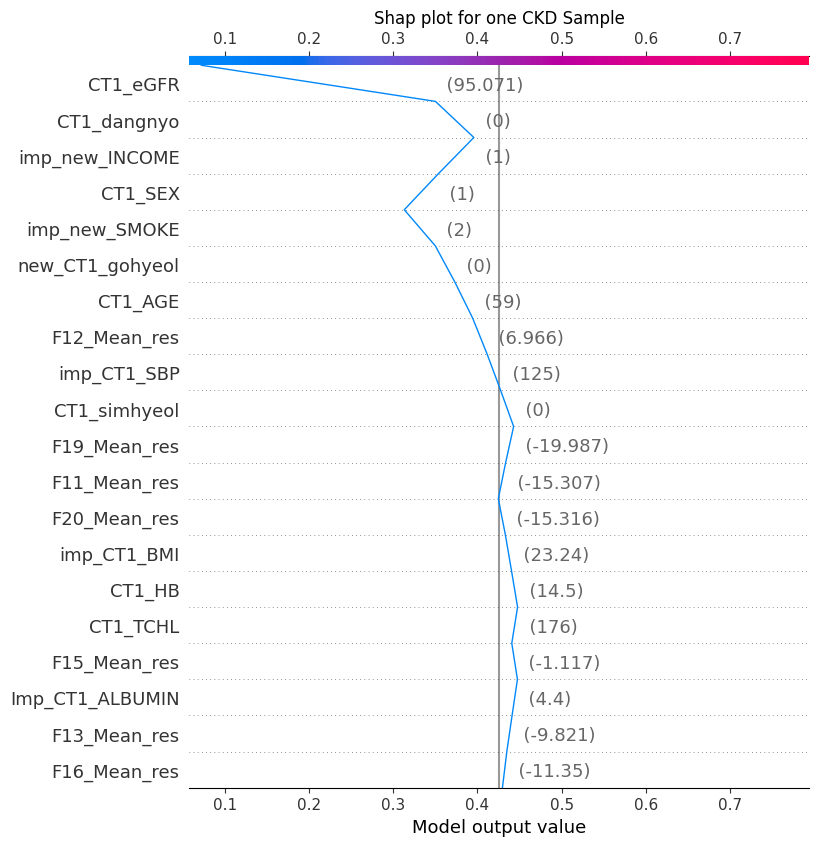

In [23]:
plt.figure()
# one ckd sample, CKD로 잘 예측한 sample.
n =11
shap.decision_plot(explainer_shap.expected_value,
                   shap_values[n],    # shape : (5, 34)
                   X_test.values[n],    # shape : (2, 34)
                   feature_names=X_train.columns.tolist(),
                   show=False
                  )
plt.title(f"Shap plot for one CKD Sample")
plt.show()

### For Control sample

For control output

In [ ]:
plt.figure()
# control sample이 ckd ( c=0 )쪽을 담당하는 output에 얼마나 기여를 했는지에 대한 shap_value를 시각화.
# 그림에서 직선의 기울기는 각 sample의 해당 column에 대한 shap_value 임.
shap.decision_plot(explainer_shap.expected_value,
                   shap_values[control_idx],    # shape : (5, 34)
                   X_test.values[control_idx],    # shape : (2, 34)
                   feature_names=X_train.columns.tolist(),
                   show=False)
plt.title("Shap plot for Control Samples")
plt.show()

In [ ]:
(outputs_of_control > 0.5)

In [ ]:
outputs_of_control[(outputs_of_control > 0.5)]

In [ ]:
# one control sample, Control로 잘 예측함.

plt.figure()
n = 66
shap.decision_plot(explainer_shap.expected_value,
                   shap_values[n],    # shape : (5, 34)
                   X_test.values[n],    # shape : (2, 34)
                   feature_names=X_train.columns.tolist(),
                   show=False)
plt.title("Shap plot for one Control Sample")
plt.show()

In [ ]:
# one control sample, for control output

plt.figure()
n = 75
shap.decision_plot(explainer_shap.expected_value,
                   shap_values[n],    # shape : (5, 34)
                   X_test.values[n],    # shape : (2, 34)
                   feature_names=X_train.columns.tolist(),
                   show=False)
plt.title("Shap plot for one Control Sample")
plt.show()

### Error samples 확인

In [ ]:
# 전체 틀린 갯수
(outputs_of_ckd < 0.5).sum().item() + (outputs_of_control > 0.5).sum().item()

In [ ]:
error_ckd = (outputs_of_ckd < 0.5).view(-1)
error_control = (outputs_of_control > 0.5).view(-1)
error_idx = torch.cat((error_ckd, error_control), dim=0)        # .view(-1, 1)

In [ ]:
total_test = pd.merge(X_test, pd.DataFrame(y_test), left_index=True, right_index=True)

In [ ]:
total_test

In [ ]:
error_testsamples = total_test[error_idx.numpy()]

In [ ]:
error_testsamples

In [ ]:
correct_testsamples = total_test[~error_idx.numpy()]

In [ ]:
correct_testsamples